# NN

## Setup


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

### Network


In [82]:
from penne1 import Net
net = Net().to(device)

from torchsummary import summary

summary(net, (3,64,64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             480
         MaxPool2d-2           [-1, 10, 12, 12]               0
         LeakyReLU-3           [-1, 10, 12, 12]               0
            Conv2d-4             [-1, 20, 6, 6]           3,200
       BatchNorm2d-5             [-1, 20, 6, 6]              40
         LeakyReLU-6             [-1, 20, 6, 6]               0
            Conv2d-7             [-1, 40, 3, 3]          12,800
       BatchNorm2d-8             [-1, 40, 3, 3]              80
         LeakyReLU-9             [-1, 40, 3, 3]               0
          Flatten-10                  [-1, 360]               0
           Linear-11                  [-1, 180]          64,800
        LeakyReLU-12                  [-1, 180]               0
           Linear-13                   [-1, 90]          16,200
        LeakyReLU-14                   

###  Example usage

In [83]:
input = torch.randn(1, 3, 64, 64).to(device)
out = net(input)
print(out)
# torch.randn(1, 3, 64, 64).to(device).get_device()


tensor([[0.5103, 0.4942, 0.5021, 0.5119]], grad_fn=<SigmoidBackward0>)


In [84]:
net.zero_grad()
out.backward(torch.randn(1, 4).to(device))



### Dataset/loader

In [85]:
from torch.utils.data import Dataset
import numpy as np
import processing
from torch.utils.data import DataLoader, random_split

from dataset import SensorDataset

dataset = SensorDataset()
train_size = round(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


1200
(array([[[  0.        , 383.67983369, 317.72634334, ..., 129.66305035,
         121.88786294,  27.4663378 ],
        [  0.        , 109.26090914, 140.91447728, ...,  97.26182147,
          39.3036044 ,  22.63083092],
        [  0.        , 319.06348777, 104.09257597, ..., 114.20548949,
          39.96777081, 124.37072329],
        ...,
        [  0.        , 272.16029737, 213.6640579 , ..., 104.70283532,
          65.34819749, 117.49720107],
        [  0.        , 584.41051758, 334.19804217, ...,  79.36461916,
         109.13611008,  37.66398598],
        [  0.        , 282.27633823, 390.88955106, ...,  94.21012375,
          35.03606074,  34.24102356]],

       [[  0.        , 328.50456998, 292.10200854, ...,  37.91827452,
          40.27890908,  91.10791133],
        [  0.        , 368.96799239, 127.82505457, ...,  26.24358698,
         134.14371901,  91.9876944 ],
        [  0.        , 186.52556915, 119.16466927, ...,  39.64235712,
          79.79051984, 134.29806672],
       

In [86]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Train

In [87]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.02)


In [88]:
import torch.optim as optim

for epoch in range(150):

    for sample, label in train_loader:
        sample = sample.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.float)

        optimizer.zero_grad()   # zero the gradient buffers
        output = net(sample)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()    # Does the update
        print(loss.item())


0.25148722529411316
0.2519552409648895
0.2515025734901428
0.25112512707710266
0.2506710886955261
0.2505946159362793
0.25011733174324036
0.2506324350833893
0.2503494620323181
0.24977564811706543
0.2497757524251938
0.24974669516086578
0.24936498701572418
0.24908584356307983
0.24903686344623566
0.24880005419254303
0.248945951461792
0.24801111221313477
0.24852879345417023
0.24860051274299622
0.2480376660823822
0.24793308973312378
0.24819210171699524
0.24780437350273132
0.2476041316986084
0.24745731055736542
0.2468353807926178
0.24648724496364594
0.24674610793590546
0.24722766876220703
0.2469186633825302
0.24641847610473633
0.24571013450622559
0.24665293097496033
0.24599148333072662
0.24549607932567596
0.24565155804157257
0.24554836750030518
0.24471712112426758
0.24479632079601288
0.24526222050189972
0.2444669008255005
0.24520446360111237
0.24504831433296204
0.24468514323234558
0.2441321462392807
0.24458591639995575
0.24442757666110992
0.24329042434692383
0.2434309422969818
0.24357946217060

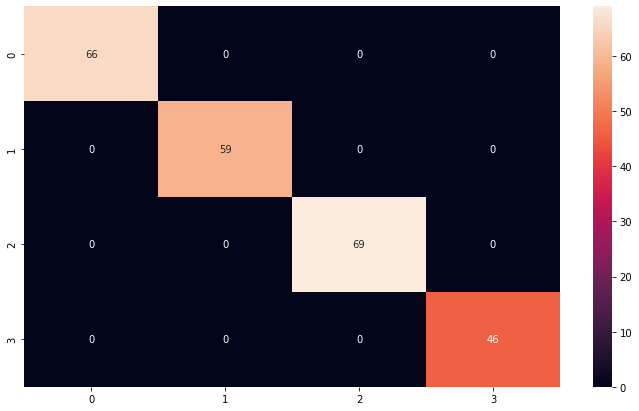

In [89]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plot

y_pred = []
y_true = []

for sample, labels in test_loader:
    sample = sample.to(device=device, dtype=torch.float)
    labels = labels.to(device=device, dtype=torch.float)

    output = net(sample)

    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction
    labels = (torch.max(labels,1)[1]).data.cpu().numpy()
    y_true.extend(labels) # Save Truth

classes = (0,1,2,3)

cf_matrix = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plot.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plot.show()


## Live test

In [1]:
import ifxdaq
import processing
import numpy as np
#print(ifxdaq.__version__)
from ifxdaq.sensor.radar_ifx import RadarIfxAvian
import matplotlib.pyplot as plot
from matplotlib.animation import FuncAnimation
import torch
device = "cuda"
config_file = "radar_configs/RadarIfxBGT60.json"

In [23]:
import cv2
no = 1
with RadarIfxAvian(config_file) as radar:                             # Initialize the radar with configurations
    
    for i_frame, frame in enumerate(radar):                           # Loop through the frames coming from the radar
        raw = frame['radar'].data
        range_doppler_map = processing.processing_rangeDopplerData(raw)
        input = torch.tensor(range_doppler_map).to(device=device, dtype=torch.float32)
        data = np.abs(np.asarray(processing.processing_rangeDopplerData(np.squeeze(raw/(4095.0)))))      

        # no = torch.argmax(net(input))
        # no += 1 #TODO:Remove
        img = np.concatenate((data[0,:,:],data[1,:,:],data[2,:,:] ))
        
        # scale the image
        scale_percent = 400 # percent of original size
        width = int(img.shape[1] * scale_percent / 100)
        height = int(img.shape[0] * scale_percent / 100)
        dim = (width, height)

        img = cv2.resize(img, dim)

        text = np.zeros(shape=(256, 256,3), dtype=np.int16)
        cv2.putText(text, text=f"{no}", org=(30, 250), fontFace=cv2.FONT_HERSHEY_TRIPLEX, 
            fontScale=8, color=(255,0,0),thickness=3)
        
        cv2.imshow("img",img)
        cv2.imshow("text",text)

        print(no)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        

In [103]:
# torch.save(net, "/Users/frenkd/Private/ec-international-2022/submission/code/model/2good2beTrue.pt")
torch.save(net.state_dict(), "models/penne1.pth")